### Ray Parallel Training Demo - Credit Card Fraud Detection

In [10]:
import time
from operator import itemgetter
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import ray

Prepare Dataset

In [11]:
wine = fetch_openml('wine-quality-red', version=1, as_frame=True, parser='auto')
X = wine.data
y = wine.target

# Convert to binary classification (good wine vs bad wine)
y = (y.astype(float) >= 6).astype(int)

print(f"Total samples: {len(X):,}")
print(f"Features: {X.shape[1]}")
print(f"Good wines: {y.sum():,} ({100*y.mean():.2f}%)")


Total samples: 1,599
Features: 11
Good wines: 855 (53.47%)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\nTraining samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")


Training samples: 1,119
Test samples: 480


In [13]:
NUM_MODELS = 10

Sequential Training

In [14]:
def train_and_score_model(
    train_set: pd.DataFrame,
    test_set: pd.DataFrame,
    train_labels: pd.Series,
    test_labels: pd.Series,
    n_estimators: int,
) -> tuple[int, float]:
    """Train a Random Forest and return n_estimators and accuracy"""
    start_time = time.time()
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=15,
        min_samples_split=5,
        random_state=42,
        n_jobs=1  # Important: use 1 job per model so Ray can parallelize
    )
    model.fit(train_set, train_labels)
    y_pred = model.predict(test_set)
    accuracy = accuracy_score(test_labels, y_pred)
    
    time_delta = time.time() - start_time
    print(f"n_estimators={n_estimators:3d}, accuracy={accuracy:.4f}, took: {time_delta:.2f}s")
    
    return n_estimators, accuracy

In [15]:
def run_sequential(n_models: int) -> list[tuple[int, float]]:
    """Train models sequentially (one after another)"""
    return [
        train_and_score_model(
            train_set=X_train,
            test_set=X_test,
            train_labels=y_train,
            test_labels=y_test,
            n_estimators=50 + 20 * j,  # 50, 70, 90, 110, ...
        )
        for j in range(n_models)
    ]

In [16]:
%%time
print("SEQUENTIAL TRAINING (one model at a time)")
sequential_results = run_sequential(n_models=NUM_MODELS)
print("\n✓ Sequential training completed!")

SEQUENTIAL TRAINING (one model at a time)
n_estimators= 50, accuracy=0.8063, took: 0.09s
n_estimators= 70, accuracy=0.7958, took: 0.08s
n_estimators= 90, accuracy=0.7958, took: 0.11s
n_estimators=110, accuracy=0.7958, took: 0.12s
n_estimators=130, accuracy=0.7979, took: 0.14s
n_estimators=150, accuracy=0.8000, took: 0.16s
n_estimators=170, accuracy=0.7979, took: 0.19s
n_estimators=190, accuracy=0.8021, took: 0.21s
n_estimators=210, accuracy=0.7958, took: 0.23s
n_estimators=230, accuracy=0.7937, took: 0.25s

✓ Sequential training completed!
CPU times: user 1.53 s, sys: 21.4 ms, total: 1.55 s
Wall time: 1.58 s


Parallel Training with Ray

In [17]:
print("\n" + "=" * 60)
print("Initializing Ray...")
if ray.is_initialized():
    ray.shutdown()
ray.init(ignore_reinit_error=True)
print("✓ Ray initialized!")


Initializing Ray...


2025-11-16 20:53:38,490	INFO worker.py:2012 -- Started a local Ray instance.


✓ Ray initialized!


In [18]:
print("\nPlacing data in Ray object store...")
X_train_ref = ray.put(X_train)
X_test_ref = ray.put(X_test)
y_train_ref = ray.put(y_train)
y_test_ref = ray.put(y_test)
print("✓ Data stored and ready for parallel workers!")


Placing data in Ray object store...
✓ Data stored and ready for parallel workers!


In [19]:
@ray.remote
def train_and_score_model_remote(
    train_set_ref: pd.DataFrame,
    test_set_ref: pd.DataFrame,
    train_labels_ref: pd.Series,
    test_labels_ref: pd.Series,
    n_estimators: int,
) -> tuple[int, float]:
    """Remote function to train Random Forest (runs in parallel)"""
    start_time = time.time()
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=15,
        min_samples_split=5,
        random_state=42,
        n_jobs=1
    )
    model.fit(train_set_ref, train_labels_ref)
    y_pred = model.predict(test_set_ref)
    accuracy = accuracy_score(test_labels_ref, y_pred)
    
    time_delta = time.time() - start_time
    print(f"n_estimators={n_estimators:3d}, accuracy={accuracy:.4f}, took: {time_delta:.2f}s")
    
    return n_estimators, accuracy

In [ ]:
def run_parallel(n_models: int) -> list[tuple[int, float]]:
    """Train models in parallel using Ray"""
    # Launch all tasks asynchronously (all at once!)
    results_ref = [
        train_and_score_model_remote.remote(
            train_set_ref=X_train_ref,
            test_set_ref=X_test_ref,
            train_labels_ref=y_train_ref,
            test_labels_ref=y_test_ref,
            n_estimators=50 + 20 * j,
        )
        for j in range(n_models)
    ]
    # Wait for all results to complete
    return ray.get(results_ref)

(pid=gcs_server) [2025-11-16 20:54:07,867 E 97990 8400925] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-11-16 20:54:08,478 E 97994 8401015] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(pid=98002) [2025-11-16 20:54:09,060 E 98002 8401165] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-11-16 20:54:09,434 E 97199 8401071] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exp

In [24]:
%%time
print("=" * 60)
print("PARALLEL TRAINING WITH RAY (all models at once)")
print("=" * 60)
parallel_results = run_parallel(n_models=NUM_MODELS)
print("\n✓ Parallel training completed!")

PARALLEL TRAINING WITH RAY (all models at once)
(train_and_score_model_remote pid=98002) n_estimators= 50, accuracy=0.8063, took: 0.10s
(train_and_score_model_remote pid=97997) n_estimators=210, accuracy=0.7958, took: 0.27s
(train_and_score_model_remote pid=97998) n_estimators=110, accuracy=0.7958, took: 0.21s

✓ Parallel training completed!
CPU times: user 11.7 ms, sys: 7.77 ms, total: 19.5 ms
Wall time: 491 ms


(train_and_score_model_remote pid=97997) n_estimators=230, accuracy=0.7937, took: 0.29s


In [25]:
print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

best_seq = max(sequential_results, key=itemgetter(1))
best_par = max(parallel_results, key=itemgetter(1))

print(f"\nBest Sequential: n_estimators={best_seq[0]}, accuracy={best_seq[1]:.4f}")
print(f"Best Parallel:   n_estimators={best_par[0]}, accuracy={best_par[1]:.4f}")
print("\n📊 Compare the 'Wall time' shown above:")
print("   Sequential should take MUCH longer than Parallel!")
print("   Expected speedup: 2-4x faster with Ray! 🚀")


PERFORMANCE COMPARISON

Best Sequential: n_estimators=50, accuracy=0.8063
Best Parallel:   n_estimators=50, accuracy=0.8063

📊 Compare the 'Wall time' shown above:
   Sequential should take MUCH longer than Parallel!
   Expected speedup: 2-4x faster with Ray! 🚀


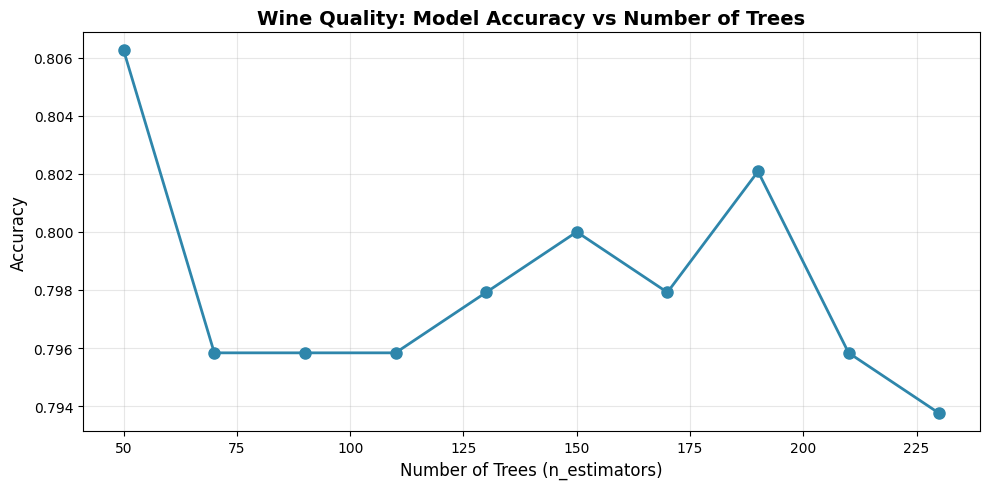

In [26]:
import matplotlib.pyplot as plt

n_est_values = [r[0] for r in sequential_results]
accuracies = [r[1] for r in sequential_results]

plt.figure(figsize=(10, 5))
plt.plot(n_est_values, accuracies, marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.xlabel('Number of Trees (n_estimators)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Wine Quality: Model Accuracy vs Number of Trees', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
ray.shutdown()
print("\n✓ Ray shutdown complete")


✓ Ray shutdown complete
